# Application

In order to obtain a better understanding of **pySmash** and its application, we introduce an examples to show a regular significant fragment extracting process. We will show the workflow of **pySmash** in *package* and *software*.

<img src="image/flow.png" style="margin-bottom:-3px" width="800" align="Center">

## Generating Significant Fragment for Chemical Carcinogens

In [118]:
# rdkit
from rdkit import Chem
# science modules
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.legend import Legend
import IPython
# Machine learning, for comparing
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.metrics import specificity_score, sensitivity_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
# Fragment generating modules
from smash import CircularLearner, PathLeanrner, FunctionGroupLearner


def buildXgbModel(X_train, y_train, **kwagrs):
    
    model = XGBClassifier(**kwagrs)
    model.fit(X_train, y_train)
    
    return model
    
def evaluateModel(y_true, y_pred):
    
#     y_pred = kwagrs.get('y_pred') or traindedModel.predict(X_test)
    
    acc = round(accuracy_score(y_true, y_pred), 3)
    sen = round(sensitivity_score(y_true, y_pred), 3)
    spe = round(specificity_score(y_true, y_pred), 3)
    pre = round(precision_score(y_true, y_pred), 3)
    
    return dict(zip(['Accurary', 'Sensitivity', 'Specificity', 'Precision'],
                    [acc, sen, spe, pre]))

In [10]:
# loading data
data = pd.read_csv('./datasets/carc/carc.txt', sep='\t')
pd.set_option('display.max_rows', 10)
data

,SMILES,Label
0,CN(c1ccc(cc1)N=Nc1ccccc1)C,1
1,CC(=O)Nc1cccc2c1c1ccccc1C2,0
2,c1cc2ccc3c4c2c(c1)ccc4ccc3,0
3,ClC(Cl)Cl,1
4,CC/C(=C(\c1ccc(cc1)O)/CC)/c1ccc(cc1)O,1
...,...,...
1111,OC(=O)C1=NN(C(=O)C1/N=N/c1ccc(cc1)S(=O)(=O)O)c1ccc(cc1)S(=O)(=O)O,1
1112,CN1C2CCC1CC(C2)NC(=O)c1cc(Cl)cc2c1OC(C2)(C)C,0
1113,O=C1C=CC(=O)C=C1,1
1114,c1ccc2c(c1)sc(n2)SSc1nc2c(s1)cccc2,0


In [21]:
# Spliting data
train = data.sample(frac=0.7, random_state=777)
test = data[~data.index.isin(train.index)]

mol_train = [Chem.MolFromSmiles(smi) for smi in train.SMILES]
mol_test = [Chem.MolFromSmiles(smi) for smi in test.SMILES]

y_train = train.Label.values
y_test = test.Label.values

print("{:8s} Positive Number: {}".format('Training', y_train.sum()))
print("{:8s} Negative Number: {}".format('Training', (1-y_train).sum()))
print("++++++++++++++++++++++++++++++")
print("{:8s} Positive Number: {}".format('Testing', y_test.sum()))
print("{:8s} Negative Number: {}".format('Testing', (1-y_test).sum()))

Training Positive Number: 520
Training Negative Number: 261
++++++++++++++++++++++++++++++
Testing  Positive Number: 238
Testing  Negative Number: 97


In [22]:
# Instantiate
cir = CircularLearner(minRadius=1, maxRadius=4, nJobs=4)
path = PathLeanrner(minPath=1, maxPath=7, nJobs=4)
fg = FunctionGroupLearner(nJobs=4)

In [25]:
# Fitting
cir.fit(mol_train, y_train)
path.fit(mol_train, y_train)
fg.fit(mol_train, y_train)

In [38]:
# The number of each fragments
print('{:8s} Fragment Number: {}'.format('Circular', len(cir.sigPvalue)))
print('{:8s} Fragment Number: {}'.format('Path', len(path.sigPvalue)))
print('{:8s} Fragment Number: {}'.format('FG', len(fg.sigPvalue)))

Circular Fragment Number: 11
Path     Fragment Number: 81
FG       Fragment Number: 7


In [34]:
# Visualizing FG fragments
IPython.display.HTML(fg.sigPvalue.to_html(escape=False))

In [26]:
# Predicting
y_pred_cir, _ = cir.predict(mol_test)
y_pred_path, _ = path.predict(mol_test)
y_pred_fg, _ = fg.predict(mol_test)
y_pred_ensemble = ((y_pred_cir + y_pred_path + y_pred_fg) >= 1) + 0

In [80]:
#Measure
res = pd.DataFrame([evaluateModel(y_test, y_pred_cir), evaluateModel(y_test, y_pred_path),
                    evaluateModel(y_test, y_pred_fg), evaluateModel(y_test, y_pred_ensemble)],
                  index=['Circular', 'Path', 'FG', 'Ensemble'])

res

,Accurary,Precision,Sensitivity,Specificity
Circular,0.516,0.888,0.366,0.887
Path,0.493,0.925,0.311,0.938
FG,0.406,0.719,0.269,0.742
Ensemble,0.627,0.812,0.618,0.649


In [67]:
# Compare with XGBoost

from scopy.ScoRepresent import CalculateECFP

X_train = CalculateECFP(mol_train, n_jobs=4)
X_test = CalculateECFP(mol_test, n_jobs=4)

model = XGBClassifier(n_estimators=800, learning_rate=0.02, 
                      max_depth=6, subsample=0.8, scale_pos_weight=0.4)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.4, seed=None,
       silent=True, subsample=0.8)

In [81]:
y_pred_xgb = model.predict(X_test)
res = res.append(pd.Series(evaluateModel(y_test, y_pred_xgb), name='XGB'))
res

,Accurary,Precision,Sensitivity,Specificity
Circular,0.516,0.888,0.366,0.887
Path,0.493,0.925,0.311,0.938
FG,0.406,0.719,0.269,0.742
Ensemble,0.627,0.812,0.618,0.649
XGB,0.630,0.806,0.630,0.629


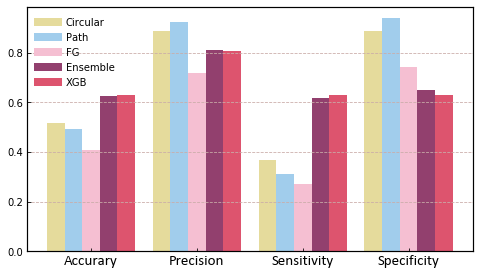

In [135]:
# Visualizing result

f,ax = plt.subplots(figsize=(8,4.5))
colors = ['#e5db9c', '#a1cdec', '#f5bfd2',
          '#92406e', '#dd546e']
width = 0.25
for center,row in zip(np.arange(1.5, 1.5*res.shape[1]+1, 1.5), res.iteritems()):
    x = np.arange(center-2*width, center+2*width+0.01, width)
    ax.bar(x, row[1].values, width=width, color=colors)

ax.spines['bottom'].set_linewidth(1.2)
ax.spines['left'].set_linewidth(1.2)
ax.spines['top'].set_linewidth(1.2)
ax.spines['right'].set_linewidth(1.2)
ax.tick_params(direction='in', which='both')
ax.set_xticks(np.arange(1.5, 1.5*res.shape[1]+1, 1.5))
ax.set_xticklabels(res.columns, fontdict={'family': 'Calibri', 'size':15})

ax.grid(ls='--', color='#caaca8', axis="y")

legend = [mlines.Line2D([0], [0], color=c, lw=8) for c in colors]
leg = Legend(ax, legend, labels=res.index, ncol=1, 
             edgecolor='white', facecolor='none', borderpad=0.6)
ax.add_artist(leg)

plt.show()

The results show that the ensemble significant fragments and XGBoost perform equally on these four evaluation parameters, and the interpretability of ensemble significant fragments is much higher than that of AI model, which will help chemists make structural modifications to toxic molecules to meet safety requirements.